<a href="https://colab.research.google.com/github/allenphos/Study-projects/blob/main/Bank%20Customer%20Churn%20Prediction/Decision_Tree_Classifier_for_Bank_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classifier for Bank Customer Churn Prediction

This analysis is based on the ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0) dataset from Kaggle, which is used in a data science competition to predict whether a customer will exit the bank.

The goal is to develop a model to predict customer churn based on these attributes. In this analysis, I’ll demonstrate how a Decision Tree Classifier can be used for this task, including model training, evaluation, hyperparameter tuning, and feature importance analysis.

## 1. Importing Libraries and Setting Up the Environment

In [ ]:
from process_bank_churn import preprocess_data, preprocess_new_data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## 2. Data Download and Preprocessing

The dataset is downloaded from Kaggle and loaded into a DataFrame. The data is preprocessed using a custom function [process_bank_churn](https://github.com/allenphos/Study-projects/blob/main/Bank%20Customer%20Churn%20Prediction/process_bank_churn.py).

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

# Download the dataset
od.download("https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2")
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

data = preprocess_data(raw_df, scale_numeric=False)

X_train = data['X_train']
train_targets = data['train_targets']
X_val = data['X_val']
val_targets = data['val_targets']


Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


## 3. Model Training and Evaluation - Initial Setup

A Decision Tree model is trained with the default settings, and its performance is evaluated on both the training and validation sets using AUROC (Area Under the Receiver Operating Characteristic Curve). The goal is to check for any signs of overfitting or underfitting.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42) # Using a fixed random_state ensures that the results are reproducible; if you run the code again, you'll get the same tree structure.

model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Функція для обчислення AUROC
def compute_auroc(inputs, targets, name=''):
    # Передбачаємо ймовірності класу 1
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Обчислюємо AUROC
    roc_auc = roc_auc_score(targets, y_pred_proba)
    print(f'AUROC for {name}: {roc_auc:.2f}')

compute_auroc(X_train, train_targets, 'Training')
compute_auroc(X_val, val_targets, 'Validation')

AUROC for Training: 1.00
AUROC for Validation: 0.76


At this point, the model shows perfect performance on the training set (AUROC = 1.0) but only achieves a score of 0.76 on the validation set, indicating overfitting.

In [ ]:
train_preds = model.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
train_probs = model.predict_proba(X_train)

train_probs[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [ ]:
model.score(X_val, val_targets) #This is a built-in method of the DecisionTreeClassifier object. It is used to evaluate the model's performance on a given dataset

0.8453333333333334

In [ ]:
model.tree_.max_depth

24

## 4. Decision Tree Model Parameters and Evaluation

The depth of the tree is examined to understand its complexity. The max_depth parameter is set to 2 to control the complexity of the tree.



In [ ]:
model = DecisionTreeClassifier(max_depth=2, random_state=42)

model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [ ]:
model.score(X_train, train_targets)

0.8651111111111112

In [ ]:
model.score(X_val, val_targets)

0.8676666666666667

## 5. Model Visualization and Feature Importance

The tree is visualized with a max_depth=2, and the feature importance is displayed. A DataFrame is created to show the importance of each feature, and it is visualized as a bar plot.

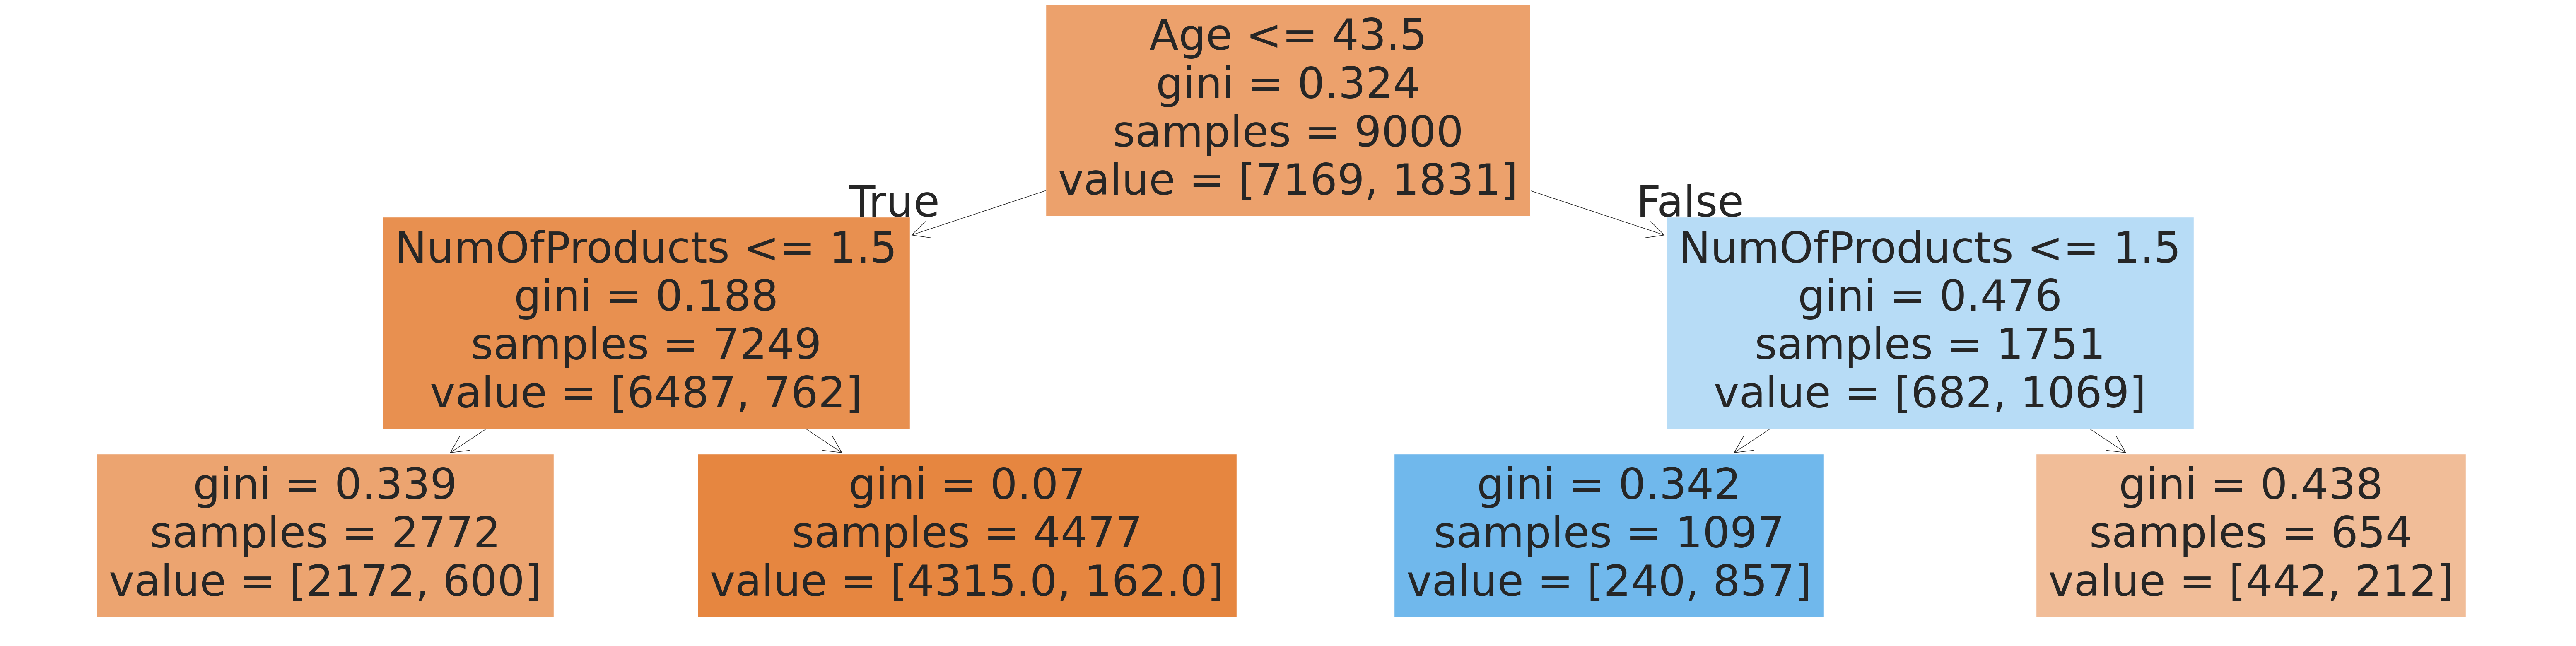

In [ ]:
from sklearn.tree import plot_tree, export_text

plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [ ]:
tree_text = export_text(model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Age <= 43.50
|   |--- NumOfProducts <= 1.50
|   |   |--- class: 0.0
|   |--- NumOfProducts >  1.50
|   |   |--- class: 0.0
|--- Age >  43.50
|   |--- NumOfProducts <= 1.50
|   |   |--- class: 1.0
|   |--- NumOfProducts >  1.50
|   |   |--- class: 0.0



In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
0,Age,0.718364
3,NumOfProducts,0.281636
1,Tenure,0.000000
2,Balance,0.000000
4,HasCrCard,0.000000
5,IsActiveMember,0.000000
6,EstimatedSalary,0.000000
7,Geography_France,0.000000
8,Geography_Germany,0.000000
9,Geography_Spain,0.000000


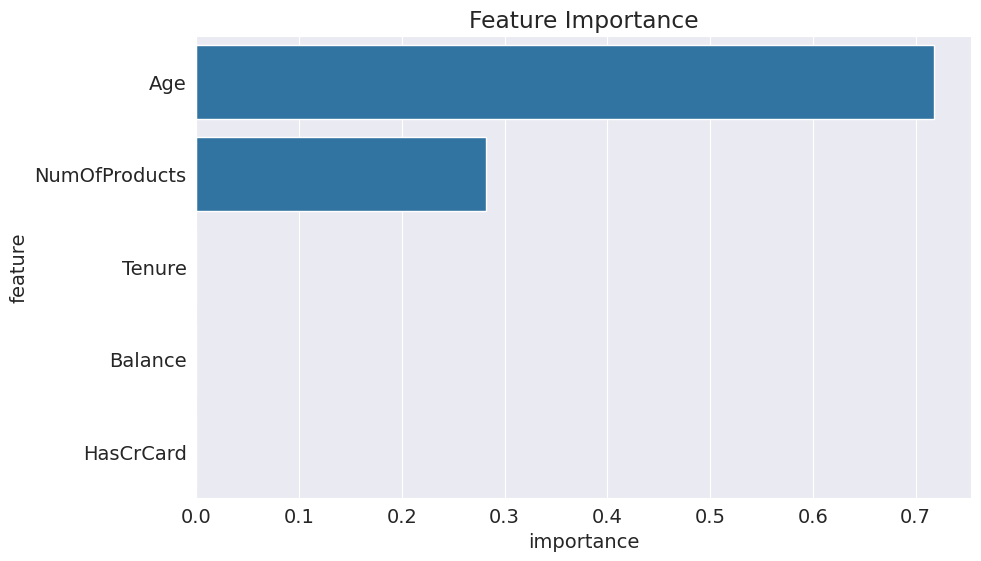

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(5), x='importance', y='feature');

From the analysis, Age and NumOfProducts are identified as the most influential features in decision-making.

## 6. Hyperparameter Tuning for Better Generalization

Different hyperparameters (max_leaf_nodes, max_depth) are tested to improve model generalization, aiming for a better AUROC score on the validation set. Initially, max_leaf_nodes=24 is used.

In [ ]:
model = DecisionTreeClassifier(max_leaf_nodes=24, random_state=42)
model.fit(X_train, train_targets)

print('Train score', model.score(X_train, train_targets))
print('Train score', model.score(X_val, val_targets))

compute_auroc(X_train, train_targets, 'Training')
compute_auroc(X_val, val_targets, 'Validation')

Train score 0.9033333333333333
Train score 0.8986666666666666
AUROC for Training: 0.92
AUROC for Validation: 0.92


In [ ]:
model.tree_.max_depth

8

In [ ]:
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train, train_targets)

print('Train score', model.score(X_train, train_targets))
print('Train score', model.score(X_val, val_targets))

compute_auroc(X_train, train_targets, 'Training')
compute_auroc(X_val, val_targets, 'Validation')

Train score 0.9042222222222223
Train score 0.8976666666666666
AUROC for Training: 0.94
AUROC for Validation: 0.92


By trial and error, the best scores are obtained by the model with max_leaf_nodes=24 and max_depth=6: AUROC for Validation: 0.92

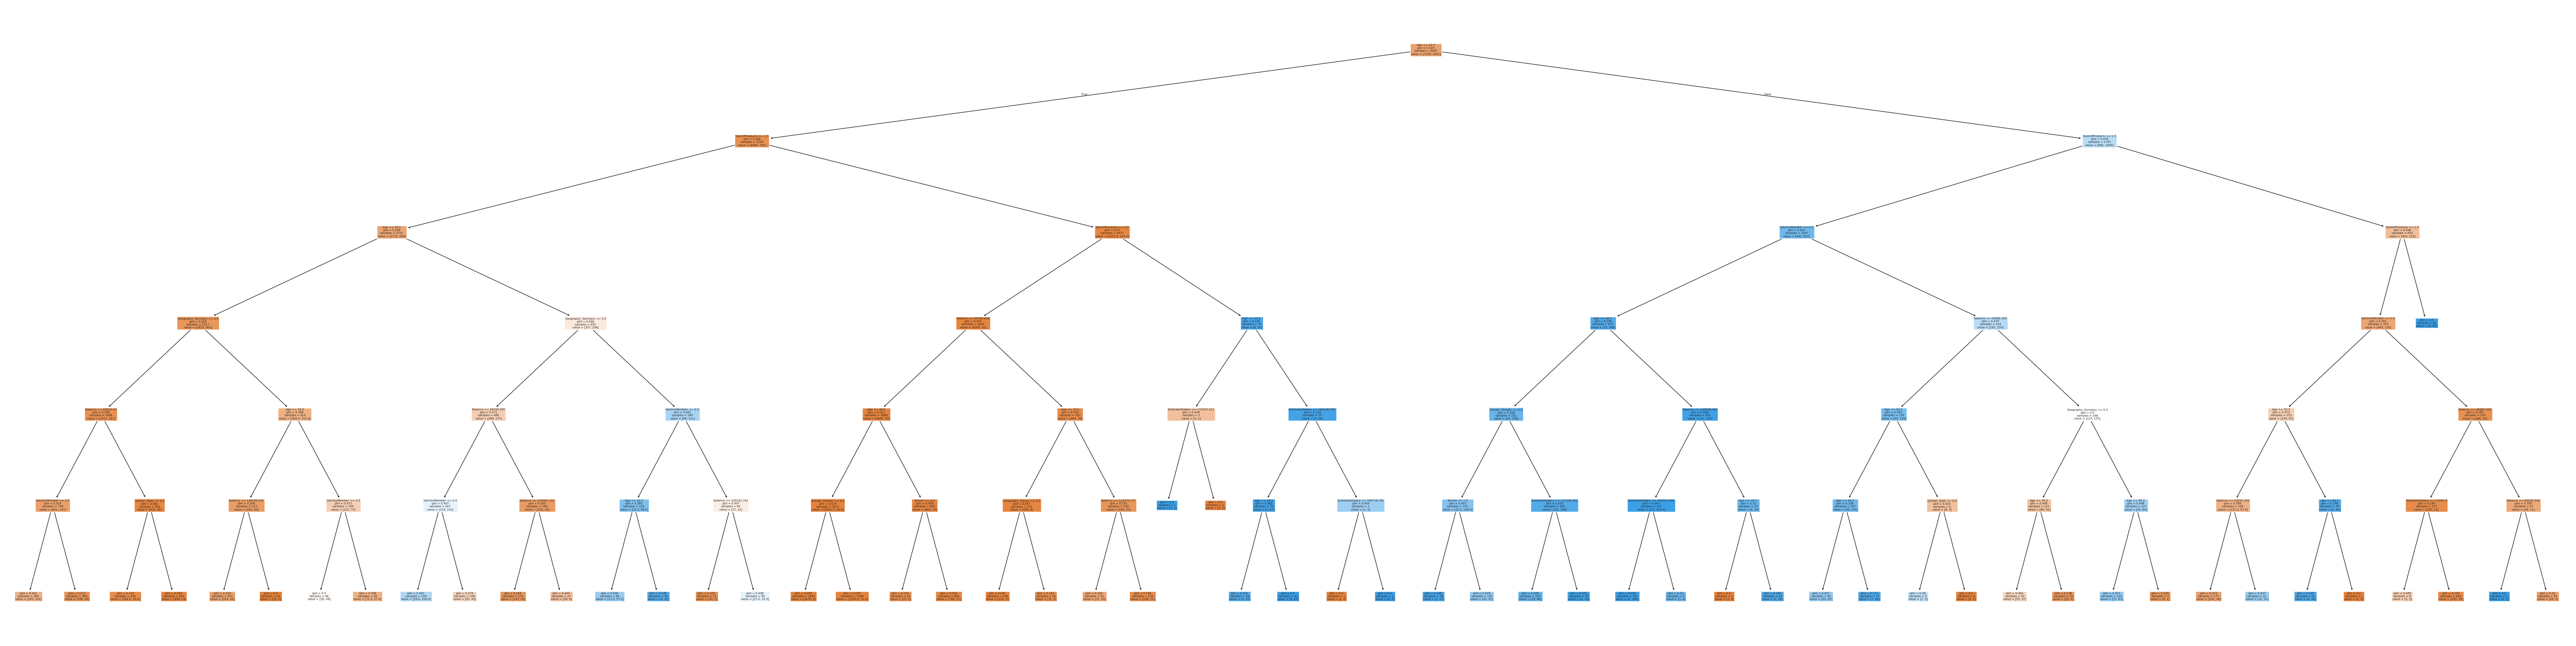

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=6, filled=True);

## 7. Optimizing Model with Depth Exploration

The model is optimized by testing different values of max_depth (from 1 to 20) to find the depth that maximizes AUROC on both training and validation sets.

In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error': val_error}

errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [ ]:
errors_df.style.background_gradient(subset='Validation Error', cmap='Blues_r')

,Max Depth,Training Error,Validation Error
0,1,0.160444,0.160333
1,2,0.134889,0.132333
2,3,0.118667,0.118000
3,4,0.112667,0.113000
4,5,0.101333,0.102333
5,6,0.095778,0.102333
6,7,0.089556,0.108333
7,8,0.080333,0.112333
8,9,0.072222,0.121000
9,10,0.060000,0.124000


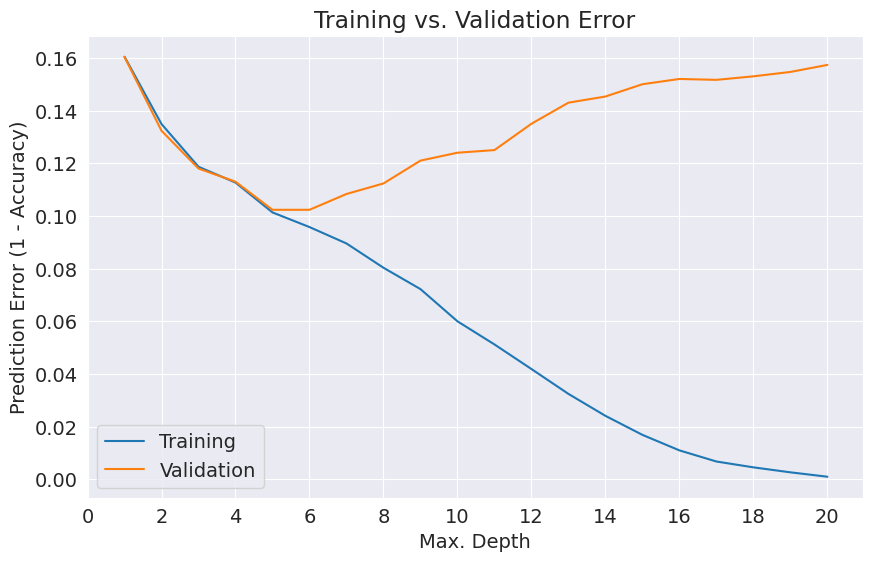

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

The model performs best with a max_depth = 5 and 6, achieving an AUROC of 0.92 on the validation set.

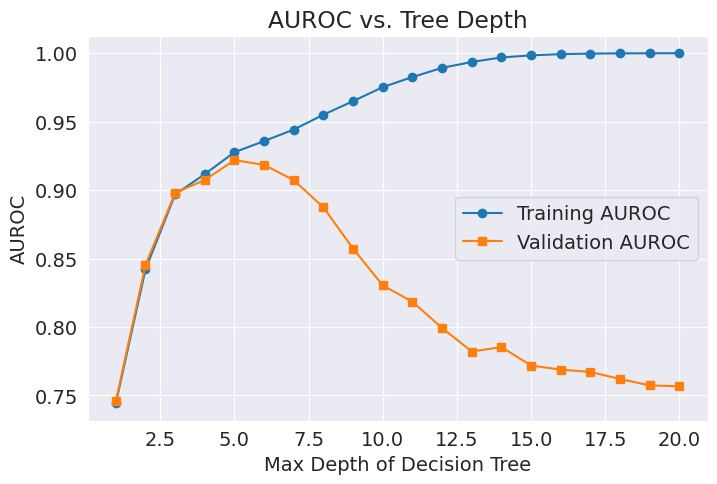

AUROC for Training: 1.00
AUROC for Validation: 0.76


In [ ]:
# Lists for storing results
depths = list(range(1, 21))
train_auroc = []
val_auroc = []

# Iterate through different depths
for md in depths:
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)

    # Predict probabilities for class 1
    train_preds = model.predict_proba(X_train)[:, 1]
    val_preds = model.predict_proba(X_val)[:, 1]

    # Calculate AUROC
    train_auroc.append(roc_auc_score(train_targets, train_preds))
    val_auroc.append(roc_auc_score(val_targets, val_preds))

# Plot AUROC vs Tree Depth
plt.figure(figsize=(8, 5))
plt.plot(depths, train_auroc, label='Training AUROC', marker='o')
plt.plot(depths, val_auroc, label='Validation AUROC', marker='s')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('AUROC')
plt.title('AUROC vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

compute_auroc(X_train, train_targets, 'Training')
compute_auroc(X_val, val_targets, 'Validation')

This step provides a visual representation of the relationship between tree depth and AUROC score, helping identify the optimal tree depth for generalization.